<h1>Dataset</h1>

<p>We begin by augmenting the 10 hours of train data (on average 6 secs each) yielding 6k training samples total. We set the sampling rate for our audio files to industry standard 16kHz (8kHz is minimum for voice). In order to input into our network, we derive important features by taking short fourier transforms in a window, and convert it into speech relevant Mel Frequency Cepstral Coefficients and derive its delta and delta delta, which in research has shown to improve speech recognition tasks. To achieve this, we set transformation parameters corresponding to industry standards for 16kHz sampling rate 23ms for n_fft (~512 frames), window size of 25ms (400 frames), and hop length of 10ms (160 frames). From this, we derive 13 mffc coefficients, and 26 for the delta and delta delta.</p>

<p>Much like in image recognition, it is good practice to augment the data. Here, there are two augmentation functions used: a random duration dilation (+/-25%), and random shift amount (within the maximum allowed sequence length of 1001, 1 + 10 secs * 16kHz / 160 frames per hop). Then we can perform cepstral mean normalization across the channels. Additionally, if there were more time, we can also implement random dropping of frequency information (zero it out), which has also been shown to improve robustness in training.</p>

<p>The most important aspect of training with a custom CTC loss function is to reorganize how inputs are passed into our network, and what inputs are passed. CTC loss requires additional information, like how long the actual labels are (before padding), so it can mask and compare the predictions to them. In addition to the training data, and labels, which must be padded, we have to provide a list of label lengths in the shape of (batch_size, 1), whose values are of each corresponding label's actual length (e.g if labels = [['dog'], ['monkey']] before padding, then label_length = [[3], [6]]. Secondly, we must provide the input_length which is also in the shape of (batch_size, 1), and whose values are the number of timesteps which will be outputted for the ctc loss. This is an important distinction because if there are maxpool layers which reduce the sequence size, the timestep value will change.<p>

In [1]:
import compose_dataset

train_fp = './en/train_clean.csv'
val_fp = './en/val_clean.csv'
test_fp = './en/test_clean.csv'

train_datagen = compose_dataset.Datagen(train_fp)
val_datagen = compose_dataset.Datagen(val_fp)

# Use augmentations for training data
augments = [train_datagen.speed_aug, train_datagen.shift_aug]
train_data = train_datagen.tensor_batch(augments=augments).repeat()

val_data = val_datagen.tensor_batch()

<h1>Model</h1>

<p>Model is straight forward, a couple of CNN layers for feature extraction and the typical batchnorm across the channels in addition to dropout regularization layers. We have to be careful how many maxpool layers we add in because the final number of timesteps must exceed 2 * max_label_length + 1. Here our max_label_length is 100, and our starting timesteps is 1001, so we can't exceed more than two maxpool layers (reducing us to 250 timesteps after). We then chain this with stacked rnns before the final softmax activation layer. Finally, this is sent into a custom loss calculation.</p>

<p>With more time, we can customize better loss functions with better scheduled learning rates in addition to a host of other hyperparameter tuning techniques.</p>

In [2]:
import ctc_model

args = {'max_chars': 28,
       'num_features': 39,
       'lr': 2e-4,
       'max_seq_length': 100,
       'timesteps': 1001,
       'drop_rate': .2}

base_model, model = ctc_model.crnn_model(args)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fcc_feats (InputLayer)       [(None, 1001, 39, 1)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1001, 39, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 1001, 39, 64)      256       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 500, 19, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 500, 19, 64)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 500, 19, 128)      73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 19, 128)     

<h1>Training</h1>

<p>Training is perhaps the most challenging aspect because CTC loss can stagnate due to various reasons (least of which that training a language model requires many examples), but even if correctly implemented, tends to predict increasingly more blanks at the start of training, until it only predicts one character at a time. This makes it difficult to diagnose if the problem is related to the data inputs, the ctc cost function itself, or various other minor details that can occur within the network architecture.</p>

<p>In this example, we can see that training proceeds as expected (after lots of debugging). We regularized our network well, so for the most part, we expect a well behaved loss function (not very jittery, and mostly monotonically decreasing). Our training settings are set at 30 steps per epoch with 32 batches per step. Therefore, we will exhaust the entirety of our training samples after 6 steps. Even with augmentation, it's expected that training on this is going to be greatly underfit. We can see both loss and val_loss decreasing nicely for this small sample, and validation loss is even under training loss. Definitely a sign of underfitting. We are on the right track!</p>

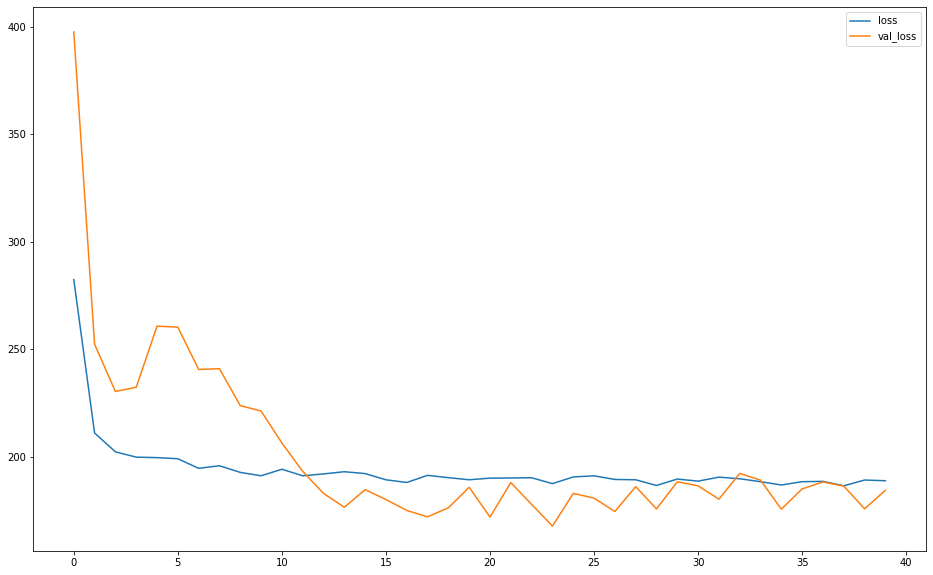

30/30 [==============================] - 66s 2s/step - loss: 188.8024 - val_loss: 184.3711


In [3]:
from custom_plot import PlotLosses

history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=40,
                    steps_per_epoch=30,
                    validation_steps=1,
                    callbacks=[PlotLosses()])

<h1>Inference</h1>

<p>Checking some predictions in inference, we can see that the network is starting to predict the first words as "the". Our training set happens to have a few that begin with 't'. Even though early stages of training yielded lots of blanks (-1 labels), the network is progressively expanding its sequence guesses.</p>

In [4]:
import tensorflow as tf
import numpy as np

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


vocab = " 'abcdefghijklmnopqrstuvwxzy"
decoder = dict(enumerate(vocab))

test_datagen = compose_dataset.Datagen(test_fp)
test_data = test_datagen.tensor_batch()

for feats, _ in test_data:
    y_pred = base_model.predict(feats)
    labels = feats[1]
    
    ctc_decodes = tf.keras.backend.ctc_decode(y_pred, greedy=False, beam_width=3, top_paths=3,
                                       input_length=np.ones(y_pred.shape[0]) * y_pred.shape[1])[0]
    
    for i, example in enumerate(ctc_decodes[0].numpy()):
        pred = example[:100]
        actual = labels.numpy()[i]
        print(''.join([decoder[i] for i in pred if i != -1]))
        print(pred)
        print(actual)
        print('')

t 
[21  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1]
[ 3 22 21  0  6 23  6 19 27 21  9 10 15  8  0  9  2  5  0  4  9  2 15  8
  6  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]

the e eaeaeaeaeae 
[21  9  6  0  6  0  6  2  6  2  6  2  6  2  6  2  6  0 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1]
[ 2  0 19  6 17 16 19 21  6 19  0  7 10 13 14 20  0  2  0 2